In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
import models
import generation_utils
import tokenizer
import data_utils

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
device = torch.device('cuda')

In [4]:
checkpoint_path = '../models/base_6/checkpoints/176_0.0911.pt'

In [5]:
checkpoint = torch.load(checkpoint_path)

In [6]:
args = checkpoint['args']

In [7]:
args['data']['data_loc']

'./data/2^16.json'

In [8]:
data_utils.gfm = data_utils.GlobalFactorMapping(data_path = '.' + args['data']['data_loc'] if args['data']['data_loc'].endswith('.json') else \
                                          args['data']['data_loc'] + '2^%d.json'%args['data']['max_pow'])

In [9]:
t = tokenizer.Tokenizer(base = args['data']['base'])

In [10]:
args.keys()

dict_keys(['data', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'tokenizer'])

In [11]:
model = models.Factorizer(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Factorizer(
  (embedding): TransformerEmbedding(
    (embedding): Embedding(10, 128)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.05, inplace=False)
          (dropout2): Dropout(p=0.05, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            

In [12]:
example_row = generation_utils.factor(69, args['data']['base'], model, t, device, args['model_args']['max_decode_size'], n_beams = 1)

In [13]:
np.exp(-0.000867)

0.9991333757359044

# Take a look at this! it's not working quite right...

In [14]:
example_row

,target_num,target_is_prime,input_string,target_str,target_factor_list,pred_str,beam_idx,log_prob,n_target_factors,pred_same_as_target,pred_factor_list,n_pred_factors,product,correct_product,correct_factorization,num_prime_factors_pred,percent_prime_factors_pred
0,69,False,153,>3x35.,"[3, 23]",>3x35.,0,-0.000012,2,False,"[3, 23]",2,69,True,True,2,1.0


In [15]:
example_row[['target_factor_list', 'pred_factor_list']]

,target_factor_list,pred_factor_list
0,"[3, 23]","[3, 23]"


In [16]:
# input = t(example_row['target_str_full'].iloc[0].replace('_', '').replace('.', ''))

In [17]:
example_row['target_num'], example_row['pred_str']

(0    69
 Name: target_num, dtype: int64,
 0    >3x35.
 Name: pred_str, dtype: object)

In [18]:
input = t(data_utils.form_input(data_utils.dec2base(example_row['target_num'].iloc[0], args['data']['base'])))
tgt = t(example_row['pred_str'].iloc[0][:-1])

In [19]:
input, tgt

([1, 5, 3, 8], [9, 3, 6, 3, 5])

In [20]:
input = torch.tensor(input).unsqueeze(0).to(device)
tgt = torch.tensor(tgt).unsqueeze(0).to(device)

In [21]:
with torch.no_grad():
    memory, memory_key_padding_mask = model.encode(input)

In [22]:
res, mem_attn, self_attn = model.decode(tgt, memory.repeat(1, tgt.size(0), 1), memory_key_padding_mask.repeat(tgt.size(0), 1), return_enc_dec_attn=True)

In [23]:
# res: Batch size x # tokens in tgt x # possible tokens
# mem_attn: # layers x # heads x # tokens in tgt # num tokens in memory
# self_attn: # layers x # heads x # tokens in tgt x # tokens in tgt
res.size(), mem_attn.size(), self_attn.size()

(torch.Size([1, 5, 10]), torch.Size([6, 8, 5, 4]), torch.Size([6, 8, 5, 5]))

In [24]:
mem_label = t(input[0].data.cpu().numpy().tolist(), decode_special=True)
tgt_label_attended_to = t(tgt[0].data.cpu().numpy().tolist(), decode_special=True)
tgt_label_attended_for = t(tgt[0].data.cpu().numpy().tolist(), decode_special=True)[1:] + '.'

In [25]:
import matplotlib as mpl
def show_attn(fig, ax, matrix, self_or_mem, title):
    ax.set_title(title)
    ax.set_yticks(np.arange(len(tgt_label_attended_for)))
    ax.set_yticklabels(labels=tgt_label_attended_for, fontsize=16)
    ax.set_ylabel('Predicting this token')
    ax.set_xlabel('Attending to this token')
    
    if self_or_mem=='self':
        other_label = tgt_label_attended_to
    elif self_or_mem=='mem':
        other_label = mem_label
    else:
        raise ValueError('bad self or mem, got %s'%self_or_mem)
    ax.set_xticks(np.arange(len(other_label)))
    ax.set_xticklabels(labels=other_label, fontsize=16)
    
    im = ax.imshow(matrix, cmap='Blues')
    fig.colorbar(im, ax=ax)

    
    if self_or_mem=='self':
        fig.set_size_inches(7,7)
    else:
        fig.set_size_inches(4,7)

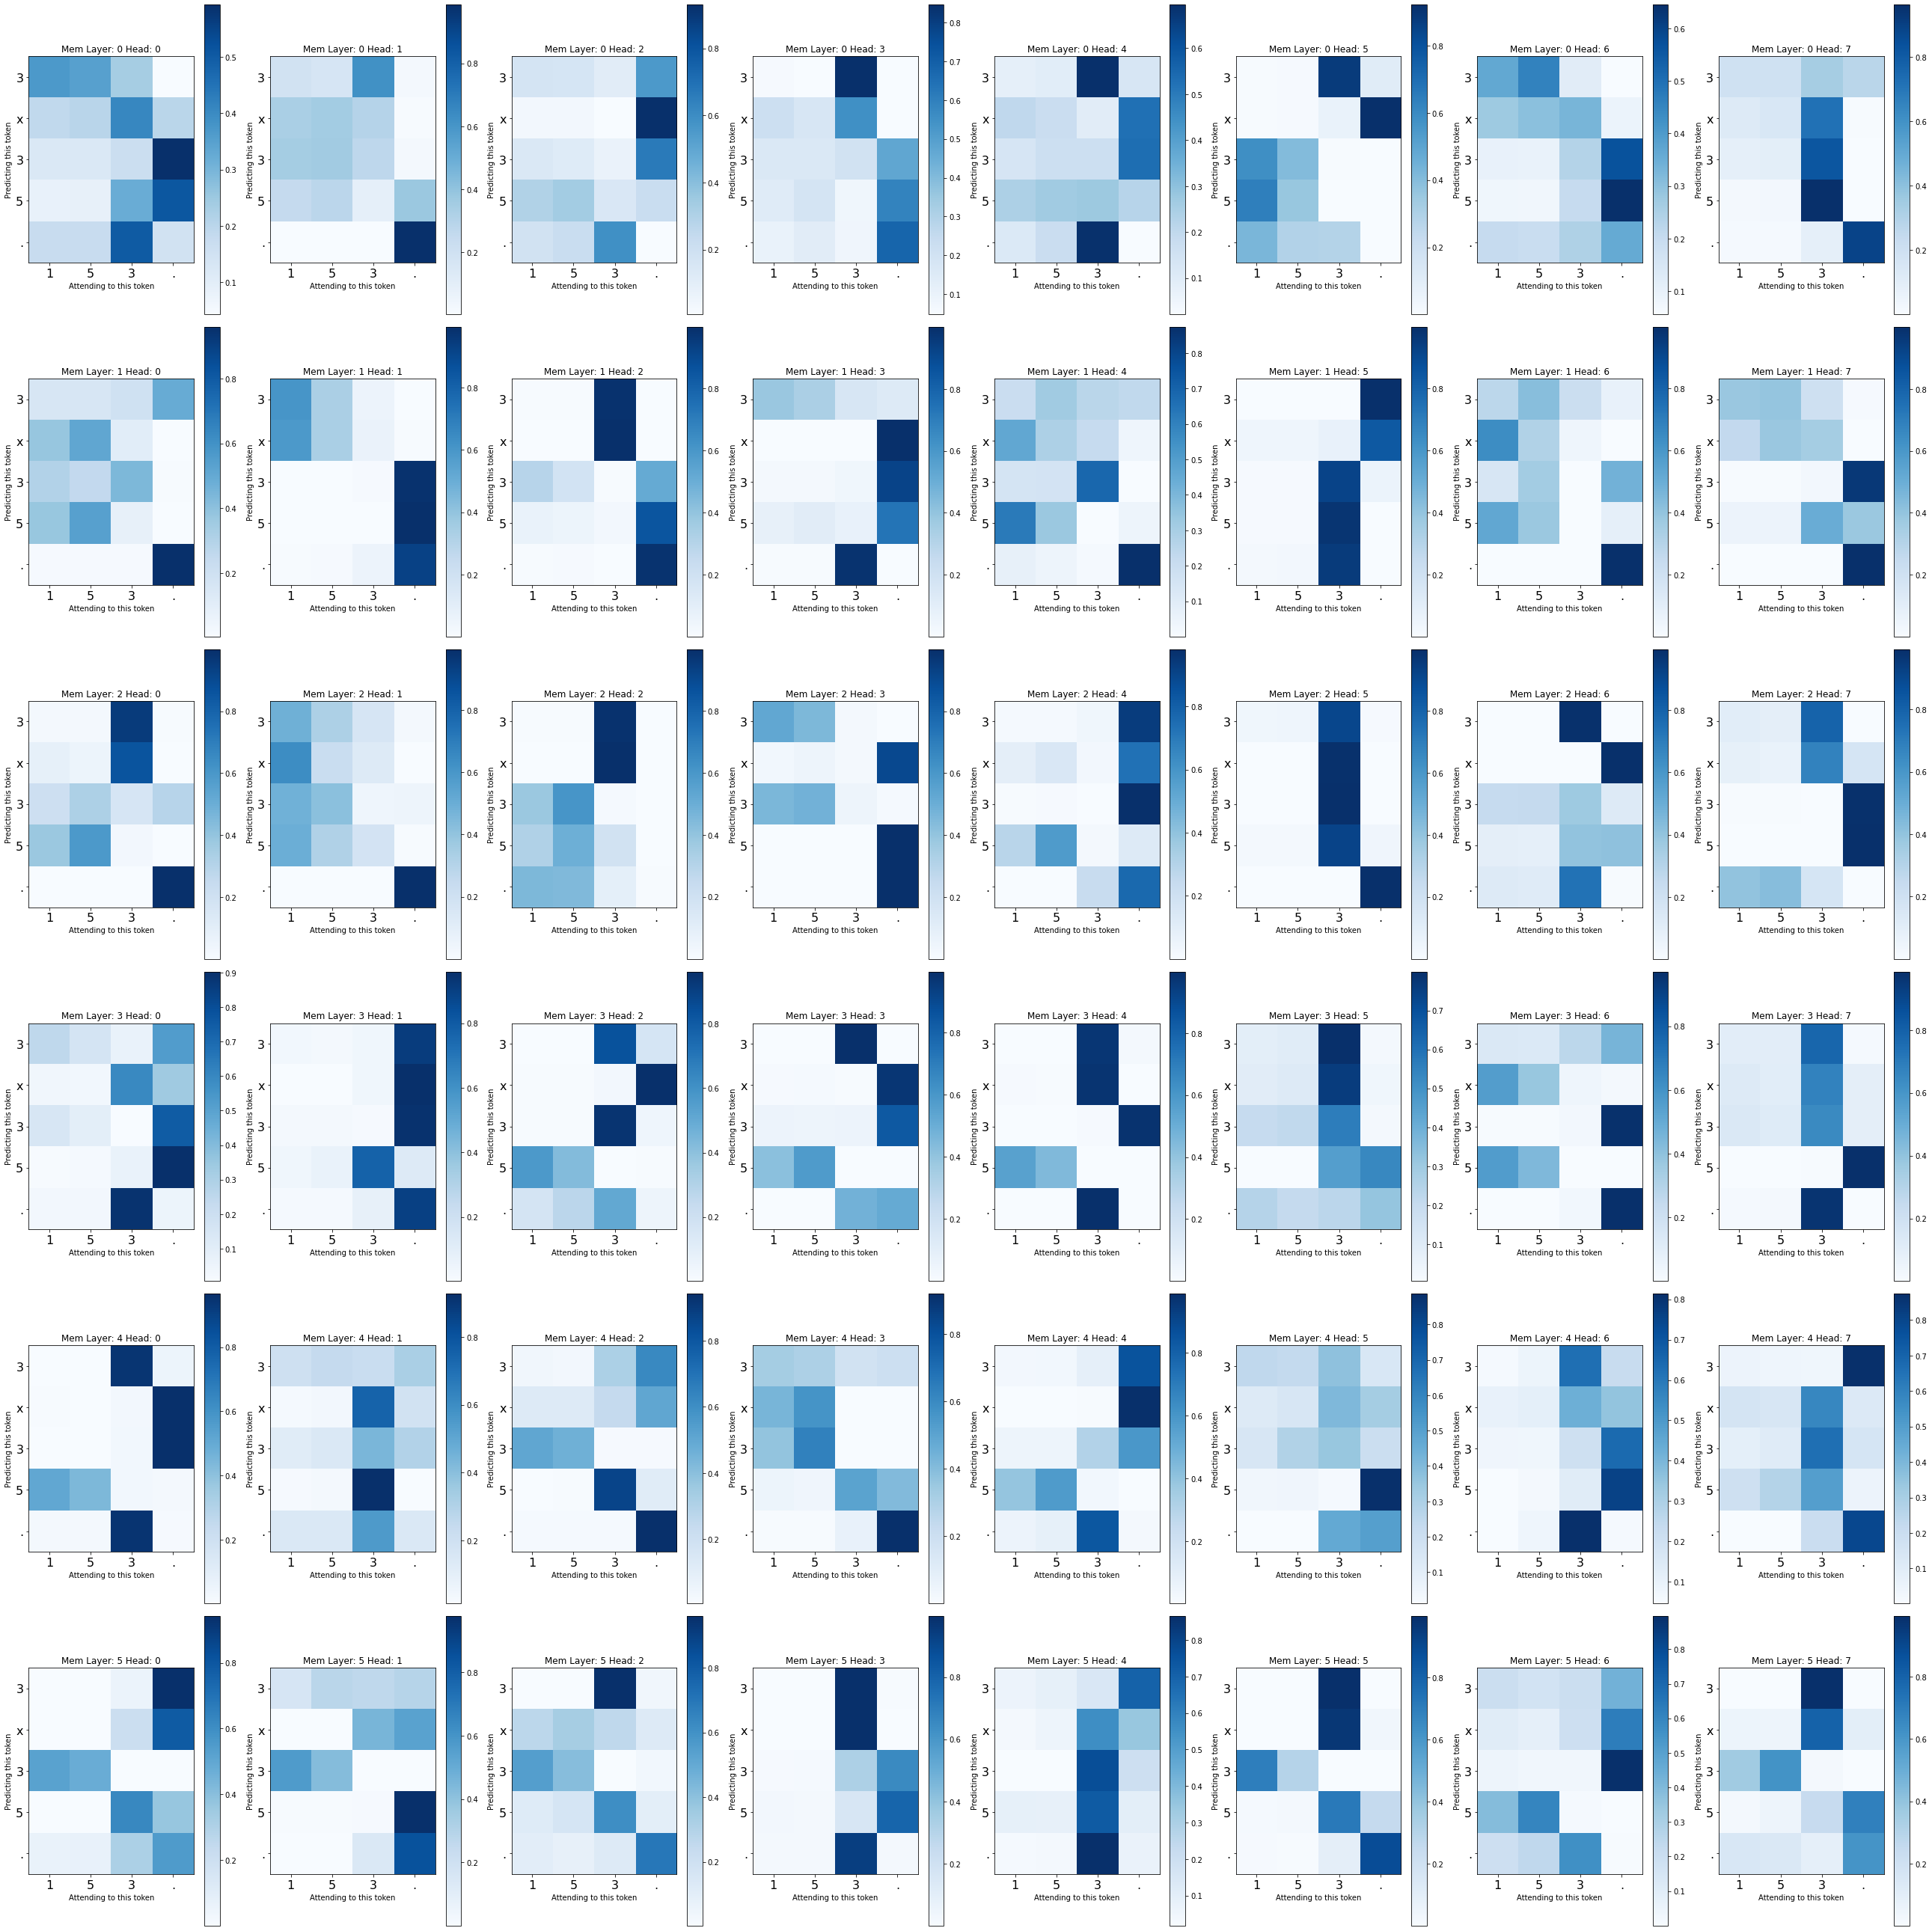

In [26]:
fig, ax = plt.subplots(mem_attn.size(0), mem_attn.size(1))

for i in range(mem_attn.size(0)):
    for j in range(mem_attn.size(1)):
        title = '%s Layer: %d Head: %d'%('Mem', i,j)
        show_attn(fig, ax[i,j], mem_attn[i][j].data.cpu().numpy(), 'mem', title)
fig.set_size_inches(36,36)
fig.tight_layout()

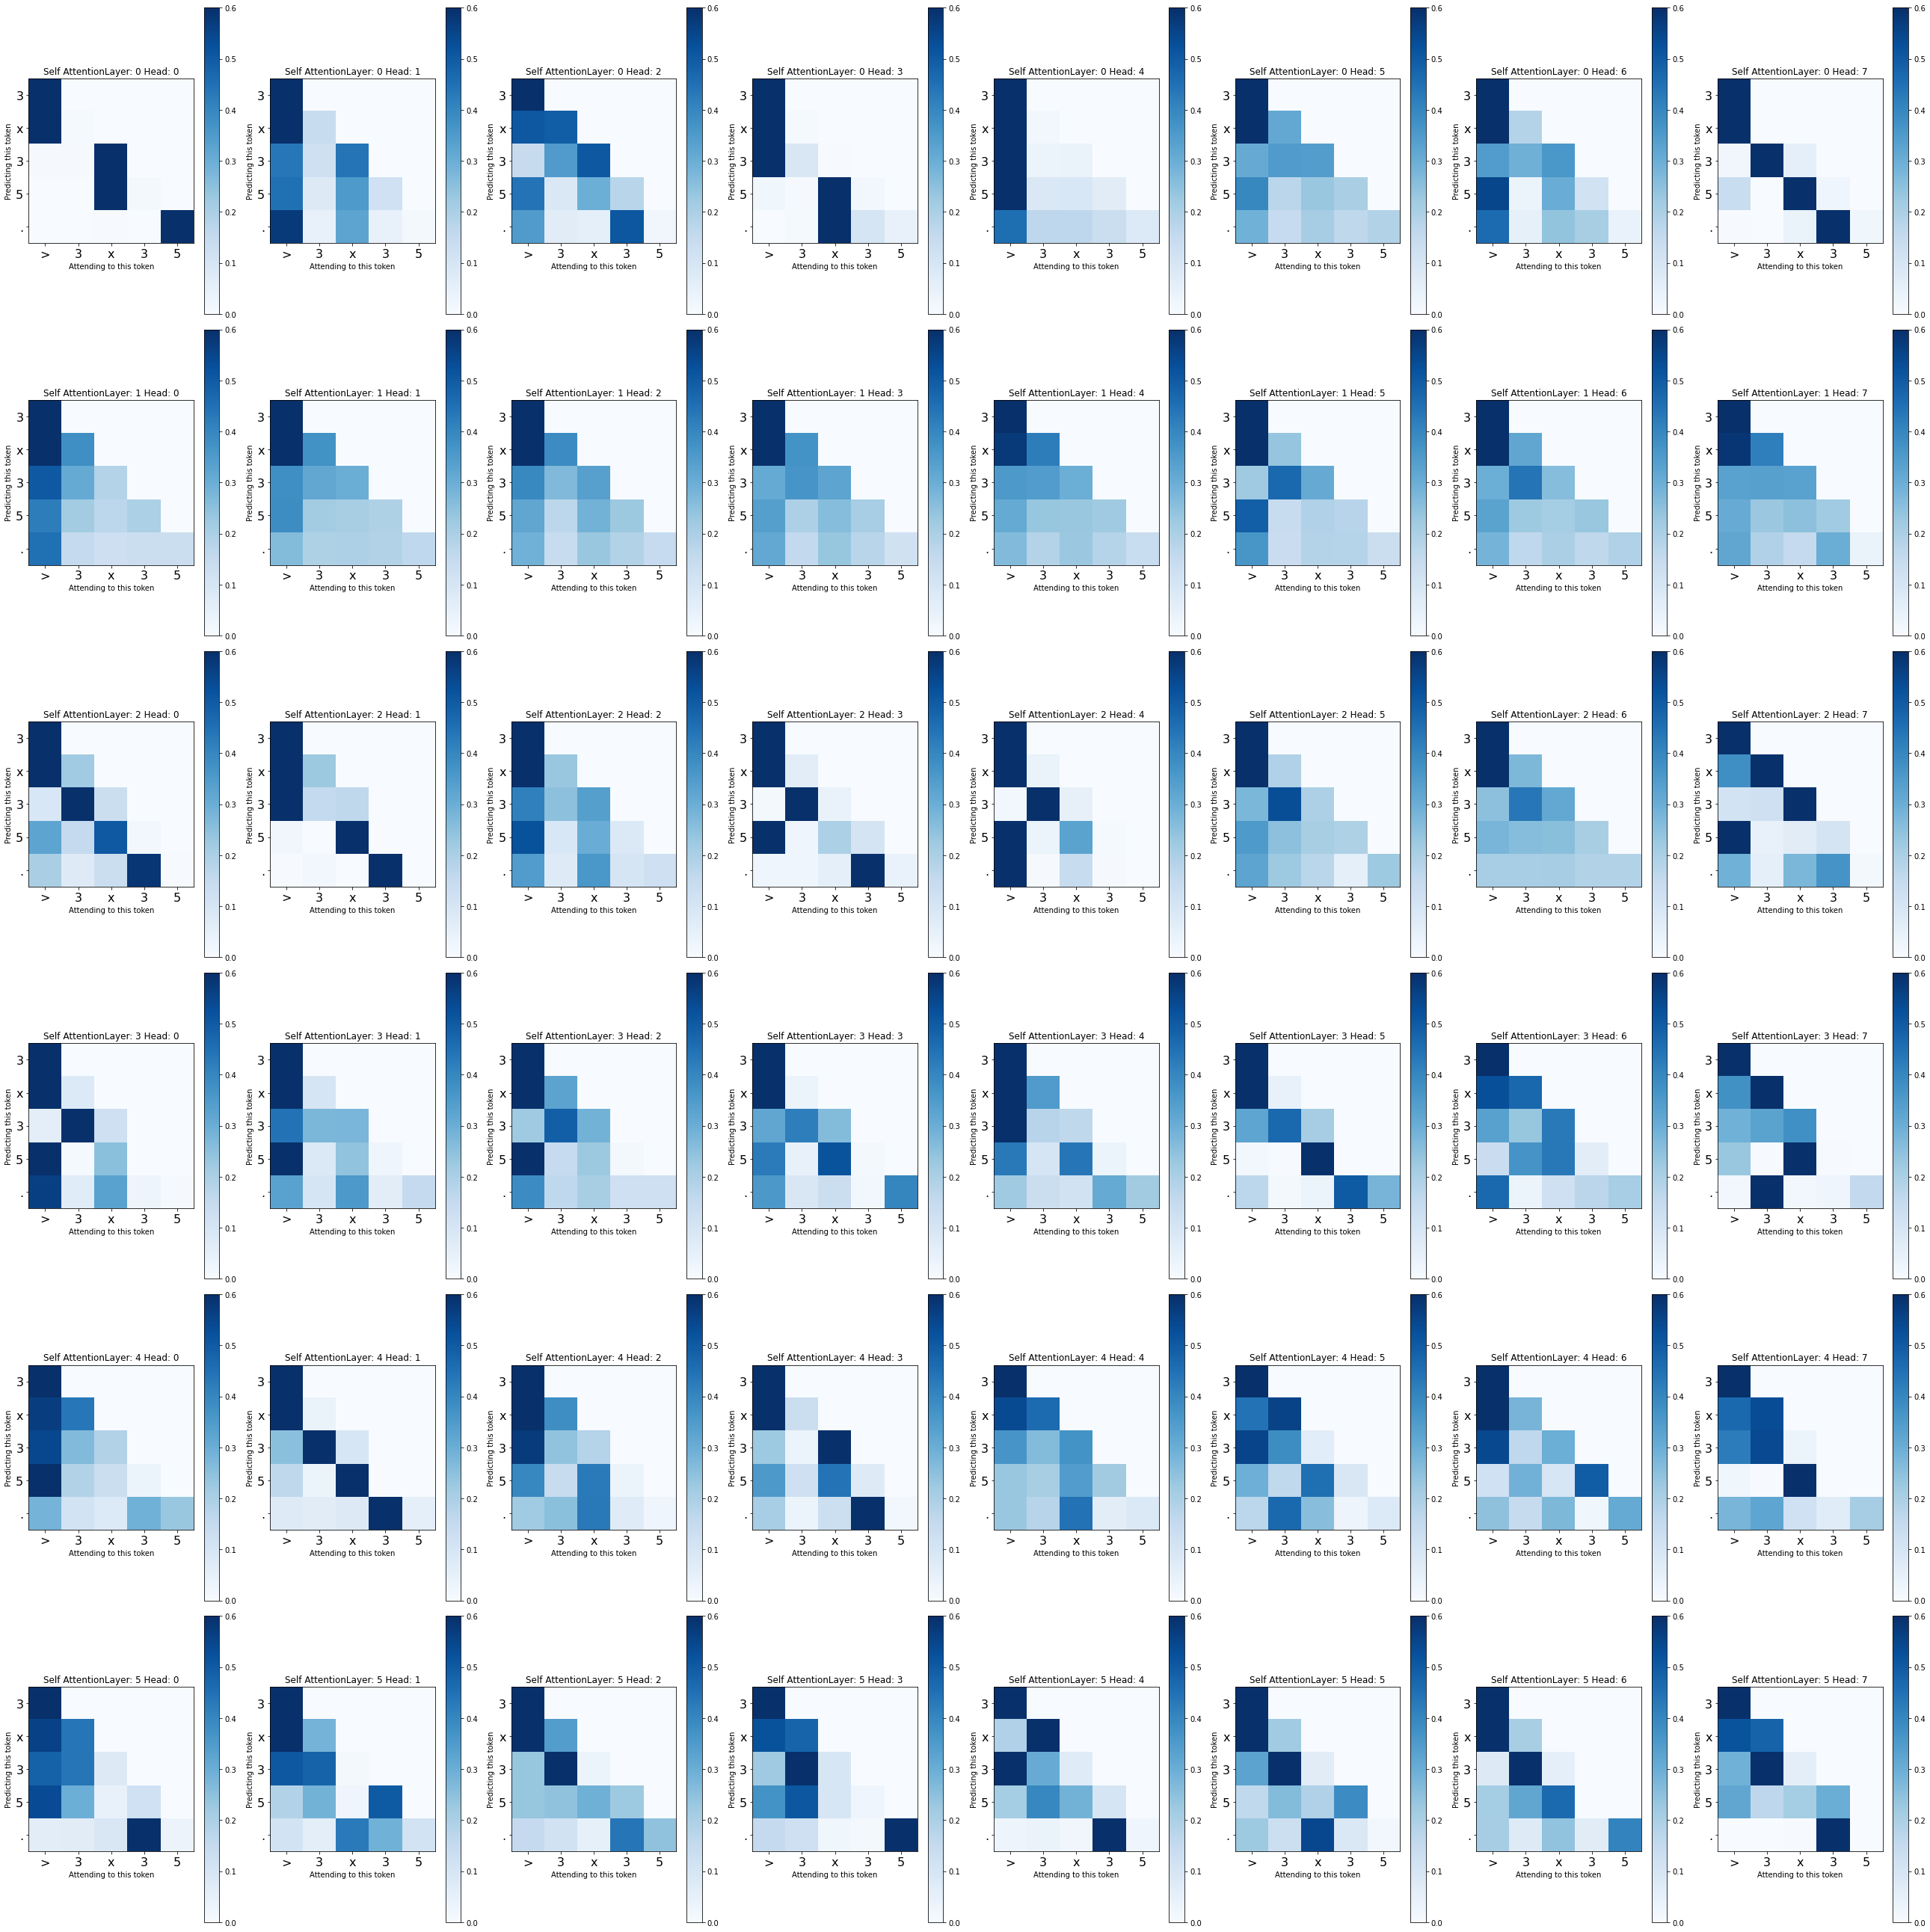

In [27]:
fig, ax = plt.subplots(self_attn.size(0), self_attn.size(1))

for i in range(self_attn.size(0)):
    for j in range(self_attn.size(1)):
        title = '%s AttentionLayer: %d Head: %d'%('Self', i,j)
        show_attn(fig, ax[i,j], np.clip(self_attn[i][j].data.cpu().numpy(), a_min=0, a_max=.6), 'self', title)
fig.set_size_inches(36,36)
fig.tight_layout()